In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split , cross_val_score , RepeatedStratifiedKFold

import warnings
warnings.filterwarnings('ignore')

In [31]:
df = pd.read_csv('diabetes.csv')# Load your dataset
df.rename(columns={'Outcome':'label'},inplace=True)
df.columns = df.columns.str.lower()
df

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [32]:
# Create a feature for insulin sensitivity (insulin * glucose)
df['insulin_sensitivity'] = df['insulin'] * df['glucose']

# Create a feature representing the product of glucose and BMI
df['glucose_bmi_product'] = df['glucose'] * df['bmi']

# Display the DataFrame with the new features
print("DataFrame with New Features:")
print(df)

DataFrame with New Features:
     pregnancies  glucose  bloodpressure  skinthickness  insulin   bmi  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     diabetespedigreefunction  age  label  insulin_sensitivity  \
0               

In [33]:
# Calculate the IQR for each column
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Identify and remove outliers based on IQR
outliers_iqr = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)
df = df[~outliers_iqr]

# Display the DataFrame without outliers using IQR
print("DataFrame without outliers (IQR method):")
print(df)

DataFrame without outliers (IQR method):
     pregnancies  glucose  bloodpressure  skinthickness  insulin   bmi  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
5              5      116             74              0        0  25.6   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     diabetespedigreefunction  age  label  insulin_sensitivity  \
0   

In [56]:
x = df.drop(columns=['label'])
y = df['label']
cols = x.columns
index = x.index

from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(x)
x = transformer.transform(x)
x = pd.DataFrame(x, columns = cols, index = index)

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((493, 10), (124, 10), (493,), (124,))

In [57]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Assuming X and y are your feature and target variables
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data only
smote = SMOTE(random_state=123)
x_resampled, y_resampled = smote.fit_resample(x_train, y_train)

In [58]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Decision Tree hyperparameter grid
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8]
}

dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_param_grid, cv=5)
dt_grid_search.fit(x_resampled, y_resampled)

best_params_dt = dt_grid_search.best_params_
best_params_dt

{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 4,
 'min_samples_split': 10}

In [59]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(criterion=best_params_dt['criterion'],max_depth=best_params_dt['max_depth'],min_samples_leaf=best_params_dt['min_samples_leaf'],min_samples_split=best_params_dt['min_samples_split'])
dtc.fit(x_resampled, y_resampled)

dtc.feature_importances_

array([0.02882066, 0.16113489, 0.01767599, 0.01311131, 0.        ,
       0.05354172, 0.0621973 , 0.24544175, 0.        , 0.41807639])

In [60]:
y_pred = dtc.predict(x_test)
decision_tree_acc = accuracy_score(y_test, y_pred)
decision_tree_acc

0.7096774193548387

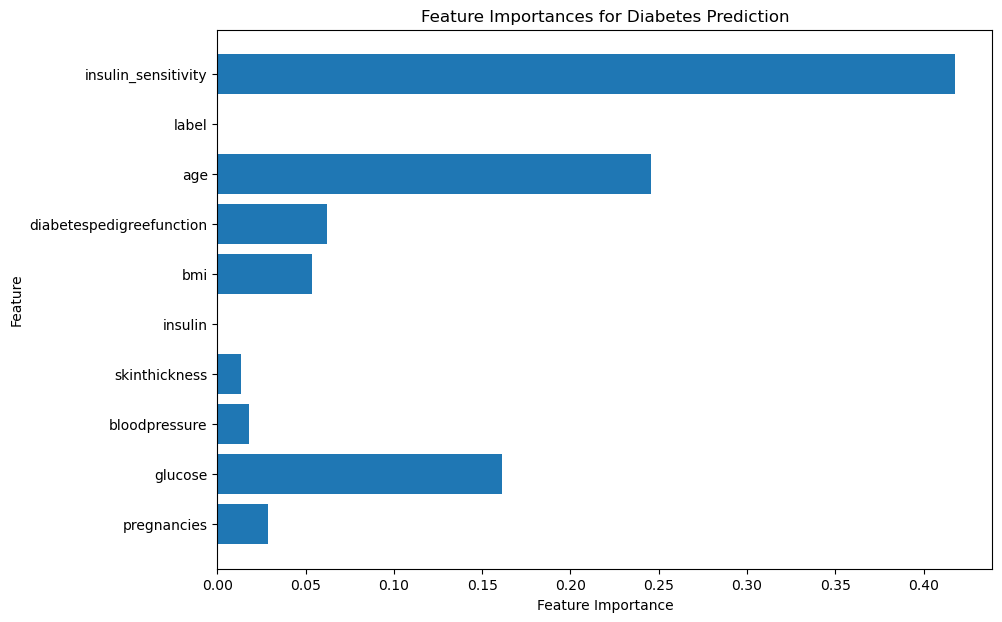

In [61]:
def plot_feature_importances_diabetes(model, feature_names):
    n_features = len(feature_names)
    
    plt.figure(figsize=(10, 7))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), feature_names)
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importances for Diabetes Prediction")
    plt.show()

# Example usage:
# Replace 'diabetes_features' with the actual list of feature names in your dataset
# Call the function with the model and feature names
plot_feature_importances_diabetes(dtc, df.columns[:-1].tolist())

In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# SVC hyperparameter grid
svc_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
}

svc_grid_search = GridSearchCV(SVC(random_state=42), svc_param_grid, cv=5)
svc_grid_search.fit(x_resampled, y_resampled)

best_params_svc = svc_grid_search.best_params_
best_params_svc

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

In [63]:
from sklearn.svm import SVC

svc = SVC(C=best_params_svc['C'],gamma=best_params_svc['gamma'],kernel=best_params_svc['kernel'])

In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Example for Random Forest hyperparameter tuning
rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5)
rf_grid_search.fit(x_resampled, y_resampled)

best_params_rf = rf_grid_search.best_params_
best_params_rf

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

In [66]:
# Example: Adjusting the maximum depth of a decision tree
model = RandomForestClassifier(max_depth=best_params_rf['max_depth'],max_features=best_params_rf['max_features'],min_samples_split=best_params_rf['min_samples_split'],min_samples_leaf=best_params_rf['min_samples_leaf'],n_estimators=best_params_rf['n_estimators'], random_state=42)

In [67]:
def train(classifier,x_train,y_train,x_test,y_test):
    
    classifier.fit(x_train,y_train)
    prediction = classifier.predict(x_test)
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 42)
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier,x_train,y_train,cv = cv,scoring = 'roc_auc').mean()))
    

def model_evaluation(classifier,x_test,y_test):
    
    y_test_pred = classifier.predict(x_test)
    y_train_pred = classifier.predict(x_resampled)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_accuracy = accuracy_score(y_resampled, y_train_pred)

    print(f"Training Accuracy: {train_accuracy}")
    print(f"Testing Accuracy: {test_accuracy}\n\n")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test,classifier.predict(x_test))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = 'Greens',fmt ='')
    
    # Classification Report
    print(classification_report(y_test,classifier.predict(x_test)))

Cross Validation Score :  95.14%
Training Accuracy: 1.0
Testing Accuracy: 0.6612903225806451


              precision    recall  f1-score   support

           0       0.70      0.82      0.76        80
           1       0.53      0.36      0.43        44

    accuracy                           0.66       124
   macro avg       0.62      0.59      0.60       124
weighted avg       0.64      0.66      0.64       124



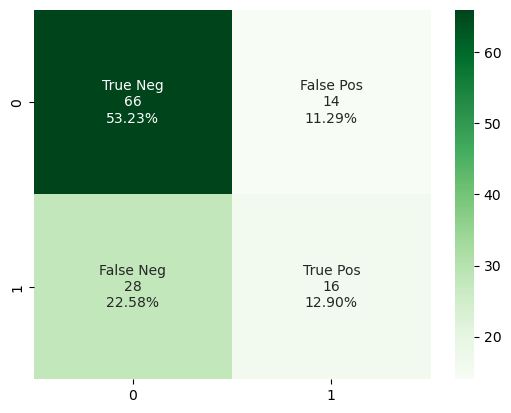

In [68]:
# Training the model
train(svc, x_resampled, y_resampled, x_test, y_test)

# Evaluate the model
model_evaluation(svc, x_test, y_test)

Cross Validation Score :  92.84%
Training Accuracy: 1.0
Testing Accuracy: 0.7419354838709677


              precision    recall  f1-score   support

           0       0.81      0.79      0.80        80
           1       0.63      0.66      0.64        44

    accuracy                           0.74       124
   macro avg       0.72      0.72      0.72       124
weighted avg       0.74      0.74      0.74       124



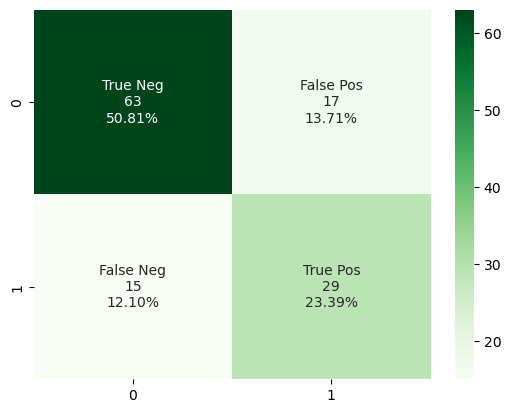

In [69]:
# Training the model
train(model, x_resampled, y_resampled, x_test, y_test)

# Evaluate the model
model_evaluation(model, x_test, y_test)

Cross Validation Score :  84.01%
Training Accuracy: 0.8654390934844193
Testing Accuracy: 0.7096774193548387


              precision    recall  f1-score   support

           0       0.79      0.75      0.77        80
           1       0.58      0.64      0.61        44

    accuracy                           0.71       124
   macro avg       0.69      0.69      0.69       124
weighted avg       0.72      0.71      0.71       124



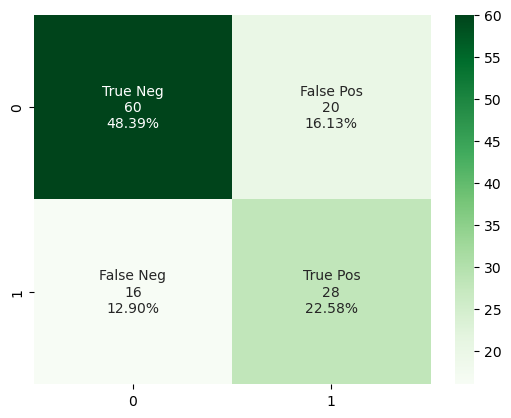

In [70]:
# Training the model
train(dtc, x_resampled, y_resampled, x_test, y_test)

# Evaluate the model
model_evaluation(dtc, x_test, y_test)